In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob

In [2]:
# programs_to_show = ['sequential_frontier_simd', 'mpi_priority_frontier_simd', 'mpi_priority_frontier', 'mpi_no_master_frontier_simd']
programs_to_show = ['mpi_priority_frontier_simd', 'mpi_priority_frontier', 'mpi_no_master_frontier_simd']
new_program = 'mpi_priority_frontier_simd'
assert new_program in programs_to_show
old_program = 'mpi_no_master_frontier_simd'
assert old_program in programs_to_show

upper_scale = 2

In [3]:
raw_benchmark_results = []
for path in glob.glob('../benchmarks/2020-12-09-euler-plan-batch-test/*.csv'):
    raw_benchmark_results.append(pd.read_csv(path))
raw_benchmark_results = pd.concat(raw_benchmark_results)

raw_benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,micros_input,micros_precompute,micros_until_len,micros_edit_script,mpi_procs
136,51,addremove,80000,1.00,0.0,zipf,0,1,mpi_no_master_frontier_simd,73476,0,432190,0,64.0
10,28,addremove,60000,0.25,0.0,zipf,0,1,mpi_priority_frontier,8194,0,57813,0,64.0
7,68,add,120000,0.50,0.0,zipf,0,1,mpi_priority_frontier_simd,29141,0,1708547,0,8.0
194,10,add,20000,1.00,0.0,zipf,0,2,sequential_frontier_simd,5561,0,1669918,0,NaN
36,11,remove,20000,1.00,0.0,zipf,0,0,mpi_priority_frontier,2005,0,42828,0,16.0


In [4]:
indexed_benchmark_results = raw_benchmark_results.set_index(['generation_config_i', 'regen_i', 'diff_program', 'repetition_i'])
indexed_benchmark_results

input_strategy  \
generation_config_i regen_i diff_program               repetition_i                  
64                  0       sequential_frontier_simd   0                 addremove   
                                                       1                 addremove   
                                                       2                 addremove   
18                  0       sequential_frontier_simd   0                 addremove   
                                                       1                 addremove   
...                                                                            ...   
70                  0       mpi_priority_frontier_simd 1                 addremove   
                                                       2                 addremove   
19                  0       mpi_priority_frontier_simd 0                       add   
                                                       1                       add   
                                                       2                       add   

                                                                     input_length_1  \
generation_config_i regen_i diff_program               repetition_i                   
64                  0       sequential_frontier_simd   0                     100000   
                                                       1                     100000   
                                                       2                     100000   
18                  0       sequential_frontier_simd   0                      40000   
                                                       1                      40000   
...                                                                             ...   
70                  0       mpi_priority_frontier_simd 1                     120000   
                                                       2                     120000   
19                  0       mpi_priority_frontier_simd 0                      40000   
                                                       1                      40000   
                                                       2                      40000   

                                                                     input_change_strength  \
generation_config_i regen_i diff_program               repetition_i                          
64                  0       sequential_frontier_simd   0                              1.00   
                                                       1                              1.00   
                                                       2                              1.00   
18                  0       sequential_frontier_simd   0                              0.50   
                                                       1                              0.50   
...                                                                                    ...   
70                  0       mpi_priority_frontier_simd 1                              0.50   
                                                       2                              0.50   
19                  0       mpi_priority_frontier_simd 0                              0.75   
                                                       1                              0.75   
                                                       2                              0.75   

                                                                     input_chunkiness  \
generation_config_i regen_i diff_program               repetition_i                     
64                  0       sequential_frontier_simd   0                          0.0   
                                                       1                          0.0   
                                                       2                          0.0   
18                  0       sequential_frontier_simd   0                          0.0   
                                                       1    

In [5]:
unique_regen_i_values = sorted(np.unique(indexed_benchmark_results.index.get_level_values('regen_i').values))
assert(unique_regen_i_values == [0])

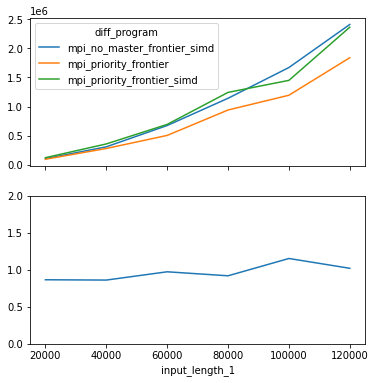

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

temp = indexed_benchmark_results.groupby(['generation_config_i', 'diff_program']).min()
temp = temp[temp.index.get_level_values('diff_program').isin(programs_to_show)]
temp = temp[temp['input_strategy'] == 'independent']
temp = temp.set_index('input_length_1', append=True)
temp = temp.unstack('diff_program')['micros_until_len']
temp = temp.droplevel('generation_config_i')
temp = temp.sort_index()

temp.plot(ax=ax[0]);
(temp[old_program] / temp[new_program]).plot(ax=ax[1], ylim=(0, upper_scale));

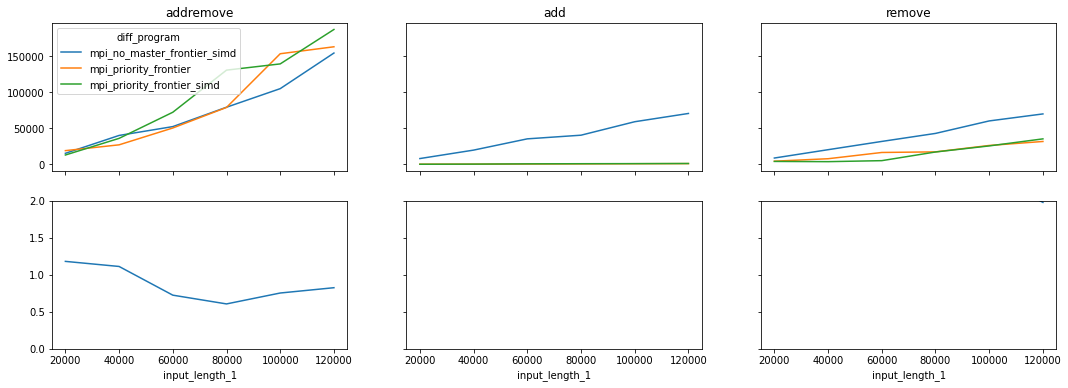

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(18, 6), sharex=True, sharey='row')
for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
    temp = indexed_benchmark_results.groupby(['generation_config_i', 'diff_program']).min()
    temp = temp[(temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == 0)]
    temp = temp[temp.index.get_level_values('diff_program').isin(programs_to_show)]
    temp = temp.set_index('input_length_1', append=True)
    temp = temp.unstack('diff_program')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()

    temp.plot(ax=ax[0][input_strategy_i], legend=(input_strategy_i == 0), title=input_strategy);
    if old_program in temp:
        (temp[old_program] / temp[new_program]).plot(ax=ax[1][input_strategy_i], ylim=(0, upper_scale));

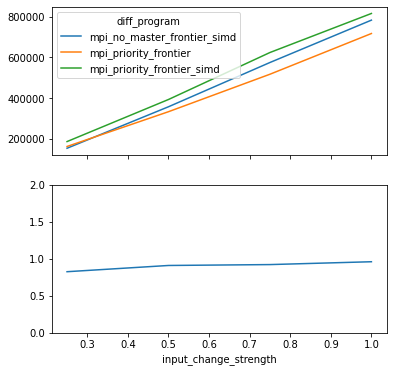

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

temp = indexed_benchmark_results.groupby(['generation_config_i', 'diff_program']).min()
temp = temp[(temp['input_strategy'] == 'addremove') & (temp['input_length_1'] == temp['input_length_1'].max()) & (temp['input_chunkiness'] == 0)]
temp = temp[temp.index.get_level_values('diff_program').isin(programs_to_show)]
temp = temp.set_index('input_change_strength', append=True)
temp = temp.unstack('diff_program')['micros_until_len']
temp = temp.droplevel('generation_config_i')
temp = temp.sort_index()

temp.plot(ax=ax[0]);
(temp[old_program] / temp[new_program]).plot(ax=ax[1], ylim=(0, upper_scale));